# 画像の埋め込みの生成（Cohere Embed3.0 - Cohere API）

In [26]:
import cohere
from PIL import Image
from io import BytesIO
import base64
import os
from dotenv import load_dotenv, find_dotenv
from pathlib import Path

In [27]:
_= load_dotenv(find_dotenv())

In [28]:
api_key = os.getenv("COHERE_API_KEY")

In [29]:
model_id = os.getenv("COHERE_EMBED_MODEL_ID")

In [30]:
co = cohere.Client(api_key=api_key)

In [31]:
def image_to_base64_data_url(image_path):
    # Open the image file
    with Image.open(image_path) as img:
        buffered = BytesIO()
        img.save(buffered, format="PNG")
        img_base64 = base64.b64encode(buffered.getvalue()).decode(
            "utf-8"
        )
    # PNG に変換したので画像フォーマットは PNG と決め打ち
    data_url = f"data:image/png;base64,{img_base64}"
    return data_url

In [32]:
from pathlib import Path
import csv

# 画像ディレクトリとサポートする拡張子を定義
image_dir_path = Path("floodnet")
supported_extensions = ['.jpg', '.JPG', '.png', '.PNG', '.webp', '.WEBP', '.jpeg', '.JPEG', 'gif', '.GIF']

# 埋め込みデータを保存する csv ファイル
output_file_path = Path("embeddings") / "floodnet_image_embeddings.csv"

# 既に処理済みの画像パスを取得
processed_images = set()
if output_file_path.exists():
    with output_file_path.open("r") as f:
        reader = csv.reader(f)
        next(reader)  # ヘッダー行をスキップ
        for row in reader:
            processed_images.add(row[1])  # パスを追加

# 画像フォルダ内のすべての画像ファイルを取得
all_image_files = [str(file) for file in image_dir_path.iterdir() if file.is_file() and file.suffix.lower() in [ext.lower() for ext in supported_extensions]]

# 未処理の画像を特定
unprocessed_images = [img for img in all_image_files if img not in processed_images]

print(f"処理済み画像数: {len(processed_images)}")
print(f"未処理画像数: {len(unprocessed_images)}")



処理済み画像数: 10
未処理画像数: 0


In [33]:
from pathlib import Path
import csv
import time
import json

# 画像ディレクトリとサポートする拡張子を定義
image_dir_path = Path("floodnet")
supported_extensions = ['.jpg', '.JPG', '.png', '.PNG', '.webp', '.WEBP', '.jpeg', '.JPEG', 'gif', '.GIF']

# 埋め込みデータを保存するファイル
output_dir_path = Path("embeddings")
output_file_path = output_dir_path / "floodnet_image_embeddings.csv"

# 既に処理済みの画像パスを取得
processed_images = set()
if output_file_path.exists():
    with output_file_path.open("r") as f:
        reader = csv.reader(f)
        next(reader)  # ヘッダー行をスキップ
        for row in reader:
            processed_images.add(row[1])  # パスを追加

# 画像フォルダ内のすべての画像ファイルを取得
all_image_files = [str(file) for file in image_dir_path.iterdir() if file.is_file() and file.suffix.lower() in [ext.lower() for ext in supported_extensions]]

# 未処理の画像を特定
unprocessed_images = [img for img in all_image_files if img not in processed_images]

if unprocessed_images:
    # 最後のインデックスを取得
    last_index = -1
    if processed_images:
        with output_file_path.open("r") as f:
            reader = csv.reader(f)
            next(reader)  # ヘッダー行をスキップ
            for row in reader:
                idx = int(row[0])
                if idx > last_index:
                    last_index = idx
    
    # 新しい埋め込みデータを生成
    new_embeddings_data = []
    for i, image_path in enumerate(unprocessed_images):
        try:
            # 画像をbase64に変換
            processed_image = image_to_base64_data_url(image_path)
            
            # 埋め込みを取得
            ret = co.embed(
                images=[processed_image],
                model=model_id,
                embedding_types=["float"],
                input_type="image",
            )
            
            # 結果を保存
            new_index = last_index + i + 1
            new_embeddings_data.append({
                "index": new_index,
                "path": image_path,
                "embedding": ret.embeddings.float[0]
            })
            print(f"画像 {i+1}/{len(unprocessed_images)} の処理が完了しました: {image_path}")
                
        except Exception as e:
            print(f"画像の処理中にエラーが発生しました: {image_path}")
            print(f"エラー: {str(e)}")
    
    # 新しい埋め込みデータをCSVファイルに追加
    if new_embeddings_data:
        # ディレクトリが存在しない場合は作成
        if not output_dir_path.exists():
            output_dir_path.mkdir(parents=True)
            print(f"ディレクトリを作成しました: {output_dir_path}")
        
        # ファイルが存在しない場合は新規作成、存在する場合は追記
        mode = "a" if output_file_path.exists() else "w"
        with output_file_path.open(mode, newline="") as f:
            writer = csv.writer(f)
            
            # 新規ファイルの場合はヘッダーを書き込む
            if mode == "w":
                writer.writerow(["index", "path", "embedding"])
            
            # 新しい埋め込みデータを書き込む
            for data in new_embeddings_data:
                embedding_json = json.dumps(data["embedding"])
                writer.writerow([data["index"], data["path"], embedding_json])
        
        print(f"{len(new_embeddings_data)}個の新しい埋め込みデータを {output_file_path} に追加しました")
    else:
        print("新しく追加された埋め込みデータはありません")
else:
    print("すべての画像はすでに処理済みです")

すべての画像はすでに処理済みです


### 画像同士の類似度計算

In [34]:
# 類似度計算関数
import numpy as np
def calculate_similarity(a, b):
    #print(f"内積：{np.dot(a, b)}")
    #print(f"ノルム：{np.linalg.norm(a)}、{np.linalg.norm(b)}")
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [35]:
# 埋め込みデータを読み込む
output_dir = "embeddings"
output_file = os.path.join(output_dir, "floodnet_image_embeddings.csv")

loaded_embeddings = []
with open(output_file, "r") as f:
    reader = csv.reader(f)
    next(reader)  # ヘッダー行をスキップ
    
    for row in reader:
        index = int(row[0])
        path = row[1]
        embedding = json.loads(row[2])  # JSON文字列から埋め込みベクトルを復元
        
        loaded_embeddings.append({
            "index": index,
            "path": path,
            "embedding": embedding
        })

# 1件目と2件目の画像の類似度を計算
if len(loaded_embeddings) >= 2:
    embedding1 = np.array(loaded_embeddings[0]["embedding"])
    embedding2 = np.array(loaded_embeddings[1]["embedding"])

    similarity = calculate_similarity(embedding1, embedding1)
    
    print(f"画像間の類似度: {similarity:.4f}")
    print(f"画像1: {loaded_embeddings[0]['path']}")
    print(f"画像1: {loaded_embeddings[0]['path']}")
    
    similarity = calculate_similarity(embedding1, embedding2)
    
    print(f"画像間の類似度: {similarity:.4f}")
    print(f"画像1: {loaded_embeddings[0]['path']}")
    print(f"画像2: {loaded_embeddings[1]['path']}")
else:
    print("類似度を計算するには少なくとも2つの画像の埋め込みが必要です")

画像間の類似度: 1.0000
画像1: floodnet\6618.jpg
画像1: floodnet\6618.jpg
画像間の類似度: 0.8089
画像1: floodnet\6618.jpg
画像2: floodnet\8472.jpg


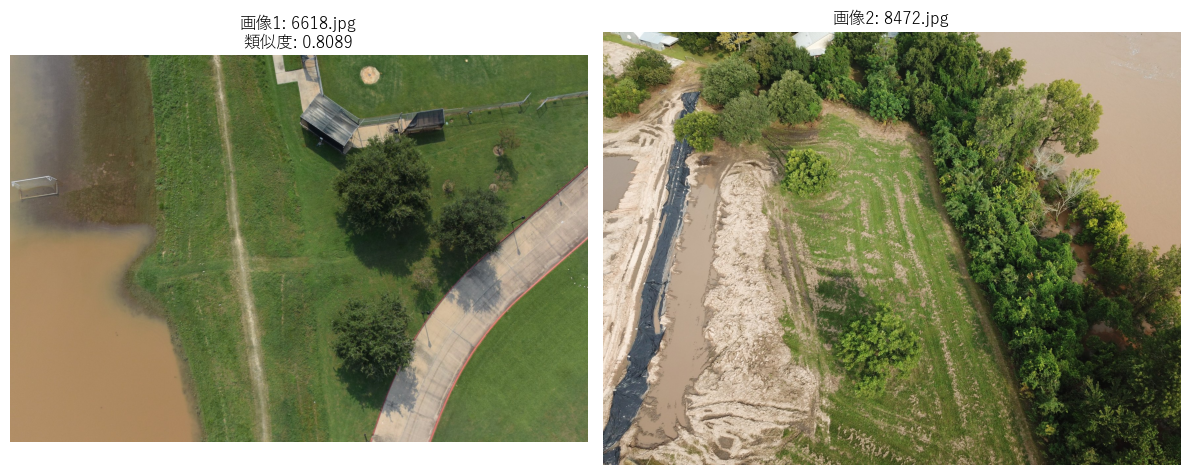

In [36]:
# 画像を表示する
from PIL import Image
import matplotlib.pyplot as plt
import japanize_matplotlib

if len(loaded_embeddings) >= 2:
    # 2つの画像のパスを取得
    image_path1 = loaded_embeddings[0]["path"]
    image_path2 = loaded_embeddings[1]["path"]
    
    # 画像を読み込む
    img1 = Image.open(image_path1)
    img2 = Image.open(image_path2)
    
    # 画像を表示
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title(f"画像1: {os.path.basename(image_path1)}\n類似度: {similarity:.4f}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title(f"画像2: {os.path.basename(image_path2)}")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("表示する画像が見つかりません")

## テキストの埋め込み生成(classification)

In [37]:
#classes = ["A satellite image of a flooded area of land.", "A satellite image of a non-flooded area of land."]
classes = ["A satellite image of a flooded area of land.", "A satellite image of a non-flooded area of land."]

In [38]:
input_type = "classification"
model_id = "embed-multilingual-v3.0"
ret = co.embed(
    texts=classes,
    input_type=input_type,
    model=model_id,
    embedding_types=["float"],
)
embeddings = ret.embeddings.float

In [39]:
len(embeddings)

2

In [40]:
len(embeddings[0])


1024

In [41]:
similarity = calculate_similarity(embeddings[0], embeddings[0])
    
print(f"テキスト間の類似度: {similarity:.4f}")
print(f"テキスト1: {classes[0]}")
print(f"テキスト1: {classes[0]}")

similarity = calculate_similarity(embeddings[0], embeddings[1])
    
print(f"テキスト間の類似度: {similarity:.4f}")
print(f"テキスト1: {classes[0]}")
print(f"テキスト2: {classes[1]}")

テキスト間の類似度: 1.0000
テキスト1: A satellite image of a flooded area of land.
テキスト1: A satellite image of a flooded area of land.
テキスト間の類似度: 0.8266
テキスト1: A satellite image of a flooded area of land.
テキスト2: A satellite image of a non-flooded area of land.


## 画像の分類

In [129]:
# カテゴリを定義
#classes = ["洪水の写真", "洪水ではない写真"]
classes = ["冠水した地域の衛星画像", "冠水していない地域の衛星画像"]
classes = ["水浸しの地域の衛星画像", "非水浸しの地域の衛星画像"]
classes = ["冠水した地域の衛星画像", "非浸水地域の衛星画像"]
classes = ["冠水の影響を受けている地域の衛星画像", "冠水の影響を受けていない地域の衛星画像"]
classes = ["a photo of a flooded,inundated,waterlogged,submerged land", "a photo of a non-flooded, non-inundated land"]
classes = ["洪水、冠水、浸水の写真", "洪水や冠水、浸水ではない写真"]
classes = ["a photo of 洪水地域", "a photo of 非洪水地域"]
classes = ["a photo of a flooded land", "a photo of a non-flooded land"]
classes = ["洪水、冠水、浸水の写真", "洪水や冠水や浸水ではない写真"]


In [130]:
input_type = "classification"
model_id = "embed-multilingual-v3.0"
ret = co.embed(
    texts=classes,
    input_type=input_type,
    model=model_id,
    embedding_types=["float"],
)
embeddings = ret.embeddings.float
class_embeddings = np.array(embeddings)
print(f"カテゴリ埋め込みの形状: {class_embeddings.shape}")

カテゴリ埋め込みの形状: (2, 1024)


In [131]:
# 画像の埋め込みデータを読み込む
output_dir = "embeddings"
output_file = os.path.join(output_dir, "floodnet_image_embeddings.csv")

loaded_embeddings = []
with open(output_file, "r") as f:
    reader = csv.reader(f)
    next(reader)  # ヘッダー行をスキップ
    
    for row in reader:
        index = int(row[0])
        path = row[1]
        embedding = json.loads(row[2])  # JSON文字列から埋め込みベクトルを復元
        
        loaded_embeddings.append({
            "index": index,
            "path": path,
            "embedding": np.array(embedding)
        })

print(f"読み込んだ画像埋め込みの数: {len(loaded_embeddings)}")

読み込んだ画像埋め込みの数: 10


In [132]:
# 類似度スコアをsoftmax関数で確率分布に変換する関数
def softmax(x):
    exp_x = np.exp(x - np.max(x))  # 数値安定性のために最大値を引く
    return exp_x / exp_x.sum()

In [143]:
results = []
for img_data in loaded_embeddings:
    img_embedding = img_data["embedding"]
    
    # 各カテゴリとの類似度を計算
    similarities = [(class_name, calculate_similarity(img_embedding, class_emb)) 
                    for class_name, class_emb in zip(classes, class_embeddings)]
    
    # 類似度から確率分布を計算
    probability_distribution = softmax(np.array([sim[1] for sim in similarities]))
    probabilities = [(sim[0], float(prob)) for sim, prob in zip(similarities, probability_distribution)]
    
    # ソート処理
    sorted_similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    sorted_probabilities = sorted(probabilities, key=lambda x: x[1], reverse=True)
    
    # 結果を保存
    results.append({
        "index": img_data["index"],
        "path": img_data["path"],
        "filename": os.path.basename(img_data["path"]),
        "category": sorted_similarities[0][0],
        "similarity": sorted_similarities[0][1],
        "probability": sorted_probabilities[0][1],
        "all_similarities": sorted_similarities,
        "probability_distribution": sorted_probabilities
    })


[('洪水、冠水、浸水の写真', 0.4676441578991055), ('洪水や冠水や浸水ではない写真', 0.478937883703519)]
[('洪水、冠水、浸水の写真', 0.49140195459747593), ('洪水や冠水や浸水ではない写真', 0.48129091899471454)]
[('洪水、冠水、浸水の写真', 0.4624927175778311), ('洪水や冠水や浸水ではない写真', 0.49281778711631385)]
[('洪水、冠水、浸水の写真', 0.42995128540065264), ('洪水や冠水や浸水ではない写真', 0.4282317355310059)]
[('洪水、冠水、浸水の写真', 0.5021086407419247), ('洪水や冠水や浸水ではない写真', 0.49033666775835866)]
[('洪水、冠水、浸水の写真', 0.47232653617153136), ('洪水や冠水や浸水ではない写真', 0.47973155096517117)]
[('洪水、冠水、浸水の写真', 0.4355817947861695), ('洪水や冠水や浸水ではない写真', 0.43778476046114606)]
[('洪水、冠水、浸水の写真', 0.4645384684493823), ('洪水や冠水や浸水ではない写真', 0.48967056161168077)]
[('洪水、冠水、浸水の写真', 0.42631755265422594), ('洪水や冠水や浸水ではない写真', 0.44098644914937496)]
[('洪水、冠水、浸水の写真', 0.4524086491261746), ('洪水や冠水や浸水ではない写真', 0.46307903208855733)]
<class 'tuple'>


In [134]:
results[0]


{'index': 0,
 'path': 'floodnet\\6618.jpg',
 'filename': '6618.jpg',
 'category': '洪水や冠水や浸水ではない写真',
 'similarity': 0.478937883703519,
 'probability': 0.5028234014411762,
 'all_similarities': [('洪水や冠水や浸水ではない写真', 0.478937883703519),
  ('洪水、冠水、浸水の写真', 0.4676441578991055)],
 'probability_distribution': [('洪水や冠水や浸水ではない写真', 0.5028234014411762),
  ('洪水、冠水、浸水の写真', 0.4971765985588238)]}

In [135]:
# 結果をDataFrameに変換
import pandas as pd
df_results = pd.DataFrame([{
    'インデックス': result['index'],
    'ファイル名': result['filename'],
    '分類カテゴリ': result['category'],
    '類似度': f"{result['similarity']:.4f}",
    '確率': f"{result['probability']*100:.2f}%"  # 確率をパーセント表示（小数点以下2桁）
} for result in results])

# DataFrameを表示
print("\n画像分類結果:")
display(df_results.style.set_properties(**{'text-align': 'left'})
        .set_table_styles([
            {'selector': 'th', 'props': [('text-align', 'left'), ('font-weight', 'bold')]},
            {'selector': '.row_heading, .blank', 'props': [('display', 'none')]},
            {'selector': 'td', 'props': [('padding', '5px')]}
        ]))


画像分類結果:


In [136]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.gridspec as gridspec
import math

# CSVファイルを読み込む
csv_path = 'floodnet/floodnet.csv'
label_data = pd.read_csv(csv_path)

# 画像と分類結果を表示する関数
def display_images_with_labels_and_predictions(label_data, classes,df_results, max_images=12):
    """
    画像とそのラベルおよび予測を表示する関数
    
    Parameters:
    -----------
    label_data : DataFrame
        画像のパスとラベルを含むデータフレーム
    df_results : DataFrame
        予測結果を含むデータフレーム
    max_images : int, optional
        表示する最大画像数（デフォルト: 12）
    """
    # 表示する画像数を制限
    display_data = label_data.head(max_images)
    display_results = df_results.head(max_images)
    n_images = len(display_data)
    
    # グリッドのサイズを計算
    n_cols = min(4, n_images)  # 最大4列
    n_rows = math.ceil(n_images / n_cols)
    
    # フィギュアを作成
    plt.figure(figsize=(16, 4 * n_rows))
    gs = gridspec.GridSpec(n_rows, n_cols)
    
    # フォントの設定（日本語対応）
    try:
        plt.rcParams['font.family'] = 'Yu Gothic'  # Windowsの場合
    except:
        pass  # フォントが見つからない場合は無視
    
    # 各画像を表示
    for i, (row, result) in enumerate(zip(display_data.iterrows(), display_results.iterrows())):
        # グリッド位置を計算
        row_pos = i // n_cols
        col_pos = i % n_cols
        
        # サブプロットを作成
        ax = plt.subplot(gs[row_pos, col_pos])
        
        try:
            # 画像を読み込んで表示
            img = Image.open(row[1]['パス'])
            ax.imshow(img)
            
            # 正解ラベルを設定
            #correct_label = "洪水の写真" if row[1]['洪水の写真'] == 'Y' else "洪水ではない"
            correct_label = classes[0] if row[1]['洪水の写真'] == 'Y' else classes[1]
            # 正解と予測が一致しているかチェック
            #match_mark = "〇" if correct_label == result[1]['分類カテゴリ'] else "×"
            match_mark = "〇" if correct_label == result[1]['分類カテゴリ'] else "×"
            # タイトルを設定
            title = (
                f"ファイル: {row[1]['パス']}\n"
                f"正解: {correct_label}\n"
                f"予測: {result[1]['分類カテゴリ']}\n"
                f"({result[1]['類似度']}, {result[1]['確率']})\n{match_mark}"
            )
            ax.set_title(title, loc='left')  # テキストを左寄せ
            
            # 軸を非表示
            ax.axis('off')
        except Exception as e:
            ax.text(0.5, 0.5, f"画像を読み込めませんでした\n{str(e)}", 
                   horizontalalignment='center', verticalalignment='center')
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# 画像とラベルおよび予測を表示（最大12枚）
display_images_with_labels_and_predictions(label_data, classes, df_results)

In [120]:
# 詳細な類似度情報を表示
print("\n詳細な類似度情報:")
for i, result in enumerate(results):
    print(f"\n画像 {i+1}: {result['filename']}")
    for category, sim in result['all_similarities']:
        print(f"  {category}: {sim:.4f}")


詳細な類似度情報:

画像 1: 6618.jpg
  a photo of 洪水地域: 0.5096
  a photo of 非洪水地域: 0.4957

画像 2: 8472.jpg
  a photo of 洪水地域: 0.5639
  a photo of 非洪水地域: 0.5144

画像 3: 6454.jpg
  a photo of 洪水地域: 0.4750
  a photo of 非洪水地域: 0.4723

画像 4: 8501.jpg
  a photo of 洪水地域: 0.5198
  a photo of 非洪水地域: 0.5016

画像 5: 8943.jpg
  a photo of 洪水地域: 0.5366
  a photo of 非洪水地域: 0.5052

画像 6: 6341.jpg
  a photo of 洪水地域: 0.5122
  a photo of 非洪水地域: 0.4998

画像 7: 8599.jpg
  a photo of 洪水地域: 0.4838
  a photo of 非洪水地域: 0.4730

画像 8: 7761.jpg
  a photo of 非洪水地域: 0.4615
  a photo of 洪水地域: 0.4575

画像 9: 8002.jpg
  a photo of 非洪水地域: 0.4883
  a photo of 洪水地域: 0.4838

画像 10: 6773.jpg
  a photo of 洪水地域: 0.4957
  a photo of 非洪水地域: 0.4846
